# Initializing

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

from morai.experience import charters

# Bayesian Inference

The Bayesian Inference is used in actuarial concepts. 
- Original workbook:
  - https://towardsdatascience.com/bayesian-inference-intuition-and-example-148fd8fb95d6
- A good paper describing how credibilty is used with actuarial is located here:
  - https://www.soa.org/globalassets/assets/files/resources/tables-calcs-tools/credibility-methods-life-health-pensions.pdf
- An open source book (Loss Data Analytics) showing credibility is used has a good example of the beta-binomial model and derivation of credibility - specifically example 9.5.1
  - https://ewfrees.github.io/Loss-Data-Analytics/C-Credibility.html#S:Cred:BayesInf

**Example:**

Let's say we have the following assumptions:
  - exposures
  - rate
  - industry_exposures
  - industry_rate

We want to calculate the rate we expect given this information

Let’s generate the data X. In real life, you don’t have any control over X. This is what you are going to observe.

## Generating Data:

In [1]:
exposures = 10000
rate = 0.02
industry_exposures = 10000
industry_rate = 0.1

In [5]:
mortality_data = np.random.binomial(n=1, p=rate, size=exposures)

In [6]:
len(mortality_data)

10000

## Conditional Probabilities

Bayesian Inference has three steps.

- **Step 1** [Prior] Choose a PDF to model your parameter θ, aka the prior distribution P(θ). This is your best guess about parameters before seeing the data X.

- **Step 2** [Likelihood] Choose a PDF for P(X|θ). Basically you are modeling how the data X will look like given the parameter θ.

- **Step 3** [Posterior] Calculate the posterior distribution P(θ|X) and pick the θ that has the highest P(θ|X).

And the posterior becomes the new prior. Repeat step 3 as you get more data.

### Prior P(θ)

The first step is to choose the PDF to model the parameter θ (the mortality rate).

Then, what kind of probability distributions should we use to model a probability?

To represent a probability, there are a few conditions to meet. First, the domain should be ranged from 0 to 1. Second, it should be a continuous distribution. There are two well-known probability distributions.

**Beta and Dirichlet**
- **Dirichlet** is for multivariate
- **Beta** is for univariate. 

We have only one thing to predict, which is a probability, so let’s use the Beta distribution.

To use a Beta distribution, there are two parameters, α & β, that we need to decide. You can think of α as How many people die and β as how many people don’tdie. These parameters — how big or small α & β are — will determine the shape of the distribution.

In [7]:
# number of deaths
a = industry_rate * industry_exposures
# number of non deaths
b = industry_exposures - a
# domain θ (0 to 1)
theta_range = np.linspace(0, 1, industry_exposures)
# prior distribution P(θ)
prior = stats.beta.pdf(x=theta_range, a=a, b=b)

Let’s plot the prior distribution with respect to all θ values.

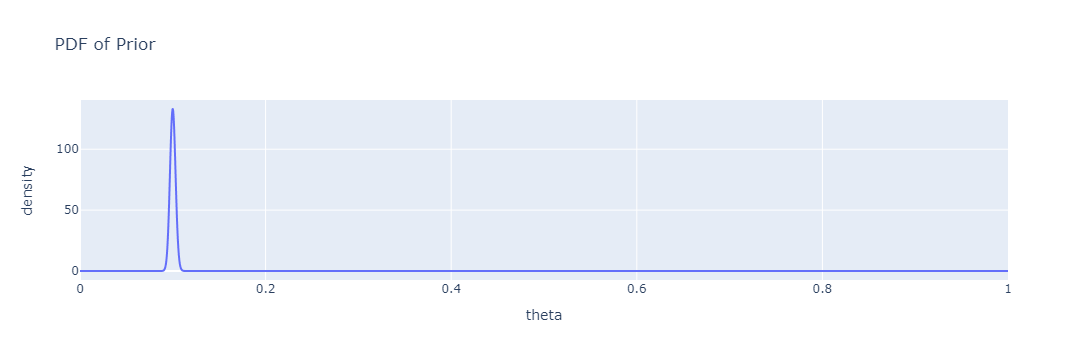

In [22]:
charters.chart(
    pd.DataFrame({"theta": theta_range, "density": prior}),
    x_axis="theta",
    y_axis="density",
    title="PDF of Prior",
)

### Likelihood P(X|θ)

Choose a probability model for P(X|θ), the probability of seeing the data X given a particular parameter θ. 

Likelihood is also called a sampling distribution. To me, the term “sampling distribution” is much more intuitive than “likelihood”.

We are choosing **Binomial distribution**

In [19]:
# The sampling dist P(X|θ) with a prior θ
likelihood = stats.binom.pmf(
    k=np.sum(mortality_data), n=len(mortality_data), p=a / (a + b)
)

Is our prior assumption θ highly likely?

In [20]:
likelihood

7.116881263328358e-228

In [21]:
# Likelihood P(X|θ) for all θ's
likelihood = stats.binom.pmf(
    k=np.sum(mortality_data), n=len(mortality_data), p=theta_range
)

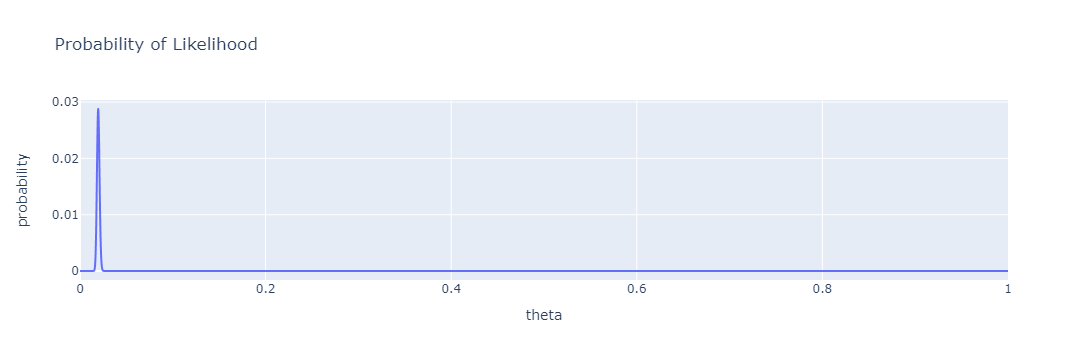

In [24]:
charters.chart(
    pd.DataFrame({"theta": theta_range, "probability": likelihood}),
    x_axis="theta",
    y_axis="probability",
    title="Probability of Likelihood",
)

### Posterior. P(θ|X)

Finally, let’s answer the question we asked in the beginning:

>Specifically, we will have a large number of data points X. How do we multiply the probability wrt X with the probability wrt θ?

Even though there are thousands of data points, we can convert them into a single scalar — the likelihood P(X|θ) — by plugging data into the model that you chose (in this example, the binomial distribution.)

Then, we calculate P(θ) & P(X|θ) for a specific θ and multiply them together. If you do this for every possible θ, you can pick the highest P(θ) * P(X|θ) among different θ’s.

Your initial guess about parameters was P(θ). Now you are upgrading a simple P(θ) into something more informative — P(θ|X) — as more data become available.

P(θ|X) is still the probability of θ, just like P(θ) is. However, P(θ|X) is a smarter version of P(θ).

In [25]:
prior = stats.beta.pdf(x=theta_range, a=a, b=b)
likelihood = stats.binom.pmf(
    k=np.sum(mortality_data), n=len(mortality_data), p=theta_range
)
posterior = likelihood * prior
normalized_posterior = posterior / np.sum(posterior)

In [26]:
np.argmax(prior) / industry_exposures

0.0999

In [27]:
np.argmax(likelihood) / industry_exposures

0.0196

In [28]:
np.argmax(posterior) / industry_exposures

0.0598

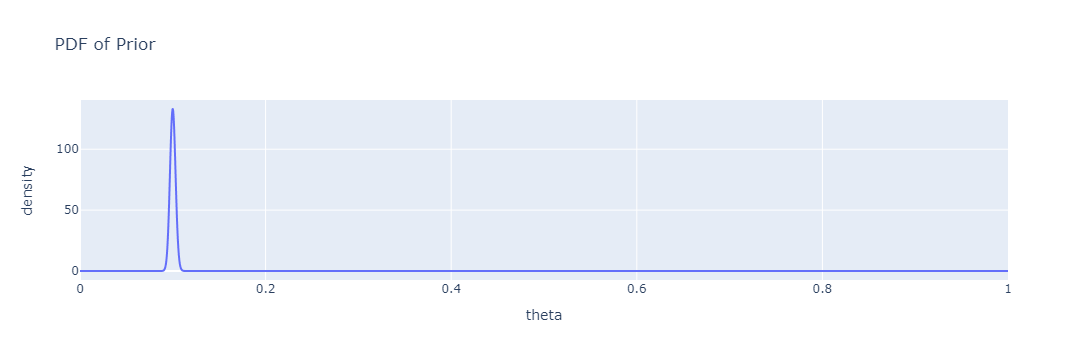

In [29]:
charters.chart(
    pd.DataFrame({"theta": theta_range, "density": prior}),
    x_axis="theta",
    y_axis="density",
    title="PDF of Prior",
)

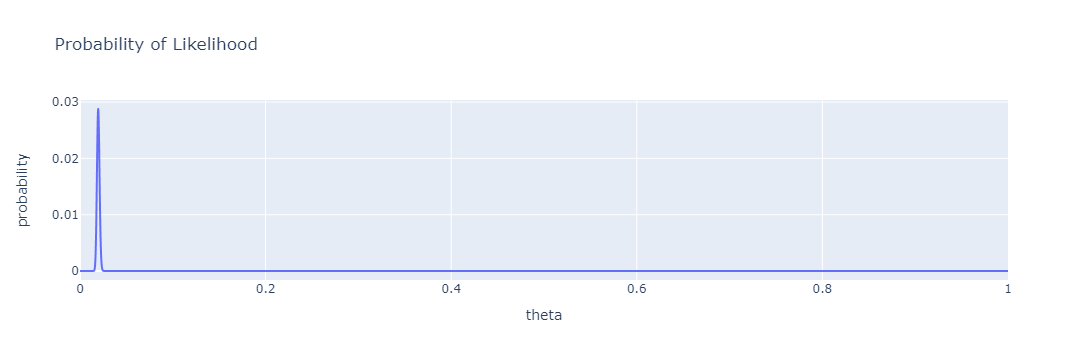

In [30]:
charters.chart(
    pd.DataFrame({"theta": theta_range, "probability": likelihood}),
    x_axis="theta",
    y_axis="probability",
    title="Probability of Likelihood",
)

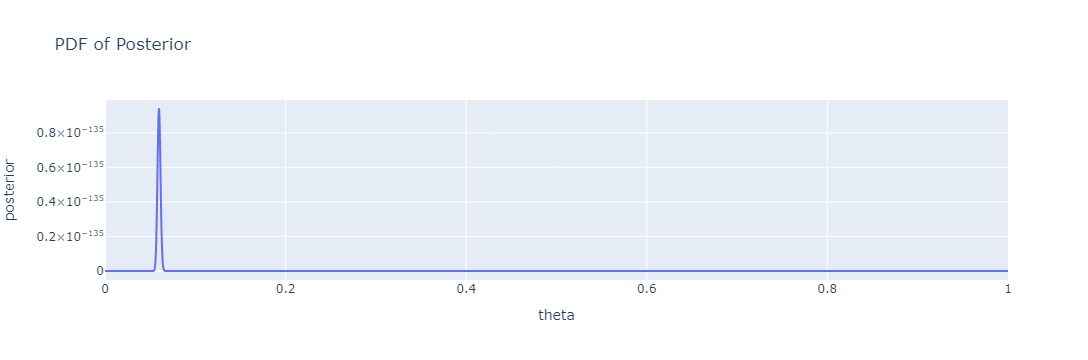

In [31]:
charters.chart(
    pd.DataFrame({"theta": theta_range, "posterior": posterior}),
    x_axis="theta",
    y_axis="posterior",
    title="PDF of Posterior",
)

## Simplified Method

In [35]:
prior_a = industry_rate * industry_exposures
prior_b = industry_exposures - a

post_a = prior_a + rate * exposures
post_b = prior_b + exposures - rate * exposures

In [36]:
prior_rate = prior_a / (prior_a + prior_b)
prior_rate

0.1

In [38]:
rate

0.02

In [37]:
post_rate = post_a / (post_a + post_b)
post_rate

0.06

# Bühlmann Credibility

As stated in `credibility methods life health pensions`

Bühlmann credibility, Least Squares credibility, and Linear Bayesian credibility. These aliases resulted from
Bühlmann’s development of a credibility method that was the least squares linear approximation to Bayesian credibility

The credibility weight, `𝑍`, was calculated to minimize the expected value of the square of the differences between the Bühlmann-weighted estimate and the Bayesian predictive mean.

$Z = \frac{n}{n+k}$

$k = \frac{EPV}{VHM}$

$EPV = Expected Process Variance$

$VHM = Variance of Hypothetical Mean$

For a binomial-beta distribution

$k = a + b$

In [39]:
prior_x = a
prior_n = a + b
prior = prior_x / prior_n
likelihood_x = sum(mortality_data)
likelihood_n = len(mortality_data)
likelihood = likelihood_x / likelihood_n
k = a + b
z = likelihood_n / (likelihood_n + a + b)

print(
    " a: {}\n b: {}\n prior: {}\n likelihood: {}\n likelihood_n: {}\n k: {}\n z: {}".format(
        a, b, prior, likelihood, likelihood_n, k, z
    )
)

 a: 1000.0
 b: 9000.0
 prior: 0.1
 likelihood: 0.0196
 likelihood_n: 10000
 k: 10000.0
 z: 0.5


In [40]:
posterior = z * (likelihood) + (1 - z) * (prior)
print(" posterior: {}".format(posterior))

 posterior: 0.059800000000000006
